In [1]:
%pylab inline
import pandas as pd
import scanpy as sc
import pickle
import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Preprocessing Hodge2019 human MTG data ...

In [2]:
# Import the human MTG data...
counts=pd.read_csv('./HodgeData/MTG/human_MTG_2018-06-14_exon-matrix.csv')
genes=pd.read_csv('./HodgeData/MTG/human_MTG_2018-06-14_genes-rows.csv')
info=pd.read_csv('./HodgeData/MTG/human_MTG_2018-06-14_samples-columns.csv')

In [3]:
counts=counts.drop('Unnamed: 0',1)

In [4]:
MTG_adata = sc.AnnData(counts.T)#, dict(var_names=ALM_genes['gene_symbol']))
MTG_adata.var_names=genes['gene']

MTG_adata.obs['class'] = list(info['class'])

subclass=list()
for each in info['cluster']:
    subclass.append(each.split(" ")[0])
MTG_adata.obs['subclass'] = subclass    
    
MTG_adata.obs['cluster'] = list(info['cluster'])
MTG_adata.obs['species'] = 'human'
MTG_adata.obs['brainArea'] = 'MTG'


    
MTG_adata

AnnData object with n_obs × n_vars = 15928 × 50281
    obs: 'class', 'subclass', 'cluster', 'species', 'brainArea'

In [5]:
np.unique(MTG_adata.obs['class'])

array(['GABAergic', 'Glutamatergic', 'Non-neuronal', 'no class'],
      dtype=object)

In [6]:
# filter the data,remove some bad cells and non-included cell types in isular data
MTG_adata = MTG_adata[MTG_adata.obs_names[~MTG_adata.obs['class'].isin(['no class'])],]

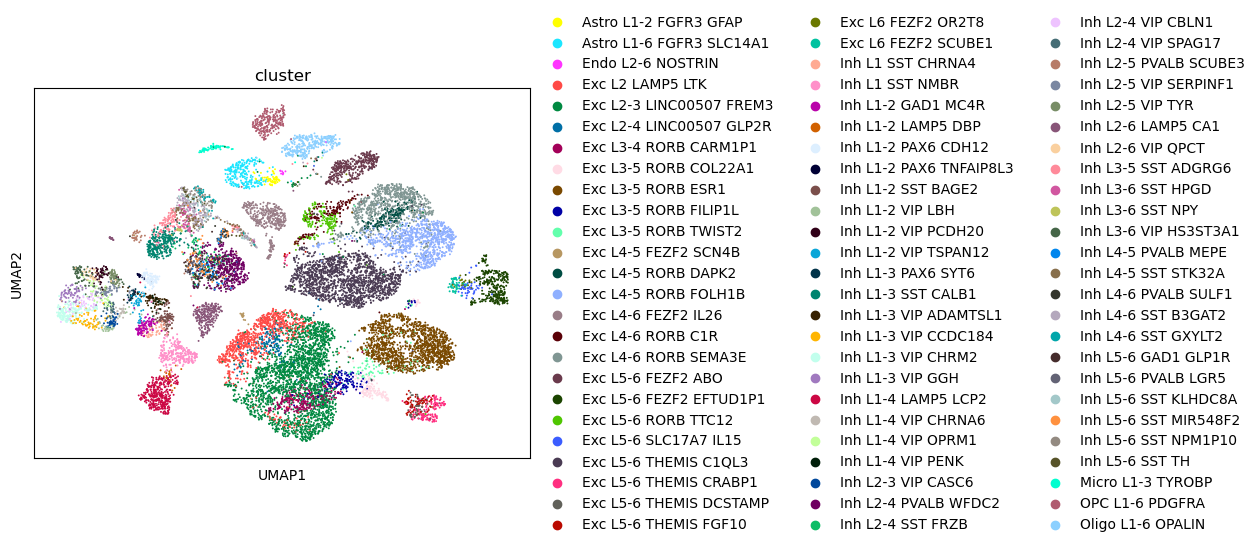

In [7]:
# run scanpy analysis pipeline
MTG_adata.layers['rawCounts'] = MTG_adata.X
MTG_adata.var['mt'] = MTG_adata.var_names.isin(["ND1","ND2","COX1","COX2","COX3","ATP6","ATP8","ND3","ND4","ND5","ND6","ND4L","CYTB"])
sc.pp.calculate_qc_metrics(MTG_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(MTG_adata, target_sum=1e4)
sc.pp.log1p(MTG_adata)
sc.pp.highly_variable_genes(MTG_adata, min_mean=0.015, max_mean=10, min_disp=0.05)

sc.pp.regress_out(MTG_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(MTG_adata, max_value=10)

sc.tl.pca(MTG_adata, use_highly_variable = True)
sc.pp.neighbors(MTG_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(MTG_adata, maxiter=200, min_dist=1, spread=2)
sc.pl.umap(MTG_adata, color=['cluster'])

In [8]:
MTG_adata.write('./HodgeData/Hodge_MTG.h5ad',compression='gzip')